In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import multiprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

In [48]:
data = pd.read_csv('../../reference/f1_cleaned.csv')
data = data.rename(columns={'driver_name' : 'team_name'})
data.drop(['code'], axis=1, inplace=True)
data.dtypes

team_name         object
driver_nat        object
circuitRef        object
year             float64
round            float64
starting_pos     float64
finishing_pos    float64
laps             float64
quali_mean       float64
driver_age       float64
driver_dnf         int64
car_dnf            int64
dtype: object

In [49]:
#train test split
#we are not using a random split here, training with pre 2024 data and trying to predict the races that occured in 2024

train = data[data.year<2024].copy()
test = data[data.year==2024].copy()

#testing set
y_test = test.pop('finishing_pos')
x_test = test

#training set
y_train = train.pop('finishing_pos')
x_train = train

In [50]:
#encoding vars and scaling data

cat_feat = ['team_name',
            'driver_nat', 
            'circuitRef']
x_num_feat = ['year',
              'round',
              'starting_pos', 
              'laps', 
              'driver_dnf', 
              'car_dnf']

#scale y later if needed for a distance model

ct = ColumnTransformer(transformers=[
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_feat), #avoid dummy var trap with OHE
    ('scx', StandardScaler(), x_num_feat)
])

In [51]:
#Basic XGB model (L2 regularization, manual preprocess as pipeline was getting error)

#fit transform train
x_train = ct.fit_transform(x_train)
regressor = XGBRegressor(objective='reg:squarederror', 
                         n_estimators=20, 
                         n_jobs=multiprocessing.cpu_count(),
                         learning_rate=0.2)
regressor.fit(x_train, y_train)

#transform test
x_test = ct.transform(x_test)
y_pred = regressor.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
print('MAE;', mae)

r2 = r2_score(y_test, y_pred)
print('R2;', r2)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', rmse)

"""
R2; 0.7532056212638376
Root Mean Squared Error: 2.8594488981674964
"""



#reattach for knowing ranks
test['pred_xgb'] = y_pred
test['finishing_pos'] = y_test

#converting to ranks
test['actual_rank'] = test.groupby('circuitRef')['finishing_pos'].rank(method='min')
test['xgb_rank'] = test.groupby('circuitRef')['pred_xgb'].rank(method='min')

#updated rank calcs
mae = mean_absolute_error(test['actual_rank'], test['xgb_rank'])
r2 = r2_score(test['actual_rank'], test['xgb_rank'])
rsme = np.sqrt((mean_squared_error(test['actual_rank'], test['xgb_rank'])))

print("Ranked MAE:", mae)
print("Ranked R²:", r2)
print("Ranked RSME:", rsme)


MAE; 2.1824983532593
R2; 0.7488315716566025
Root Mean Squared Error: 2.884677265723082
Ranked MAE: 1.9686847599164927
Ranked R²: 0.7533013134215263
Ranked RSME: 2.8588944824521607


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
#df created to compare results 

comparison_df = pd.DataFrame({
    'Team': test['team_name'],              
    'Circut': test['circuitRef'],          
    'Actual Pos': y_test,                         
    'Predicted Pos': y_pred                       
})

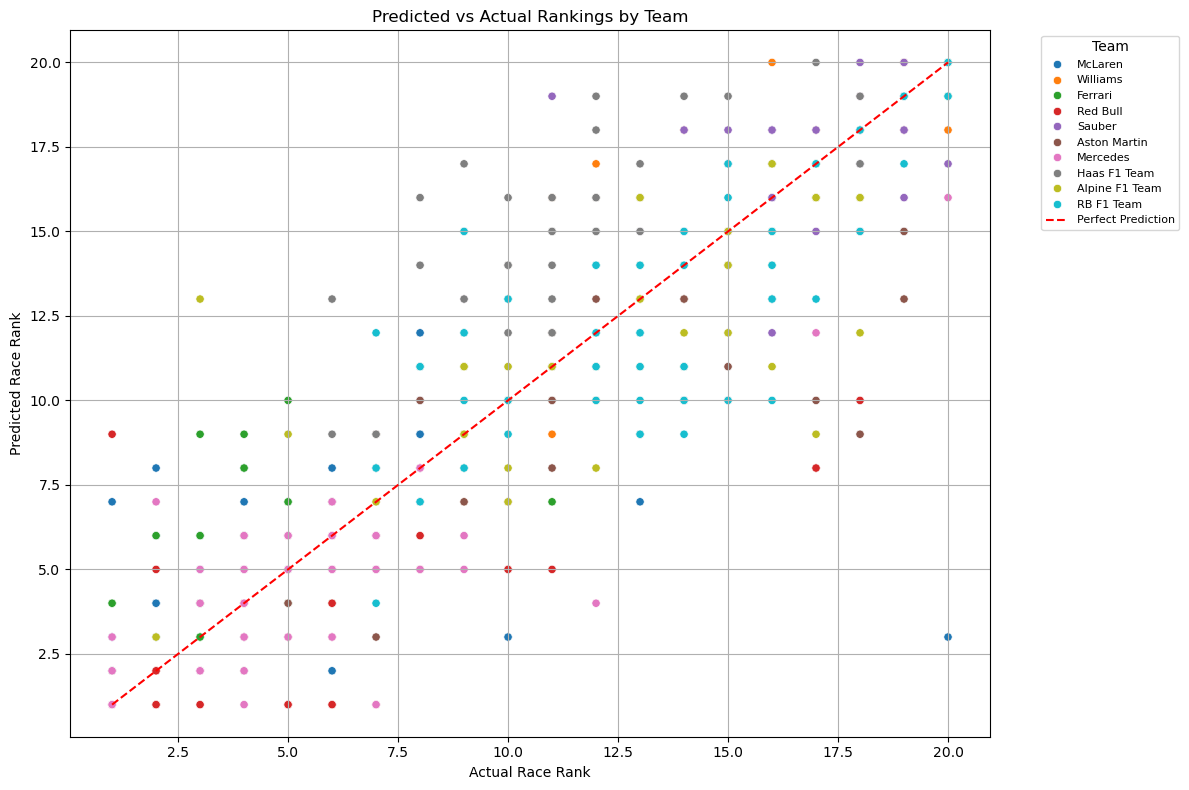

In [12]:
test = test.copy()
test['y_pred'] = y_pred
test['y_true'] = y_test.values


test['actual_rank'] = test.groupby('circuitRef')['y_true'].rank(method='min')
test['predicted_rank'] = test.groupby('circuitRef')['y_pred'].rank(method='min')


plt.figure(figsize=(12, 8))
sns.scatterplot(x='actual_rank', y='predicted_rank', hue='team_name', data=test)

#regression line
plt.plot([1, test['actual_rank'].max()], [1, test['actual_rank'].max()], 'r--', label='Perfect Prediction')

plt.xlabel('Actual Race Rank')
plt.ylabel('Predicted Race Rank')
plt.title('Predicted vs Actual Rankings by Team')
plt.legend(title='Team', prop={'size': 8}, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/gb/q_14btsd7vq8jrly_35pxk_m0000gn/T/ipykernel_10970/4127589939.py:60: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})


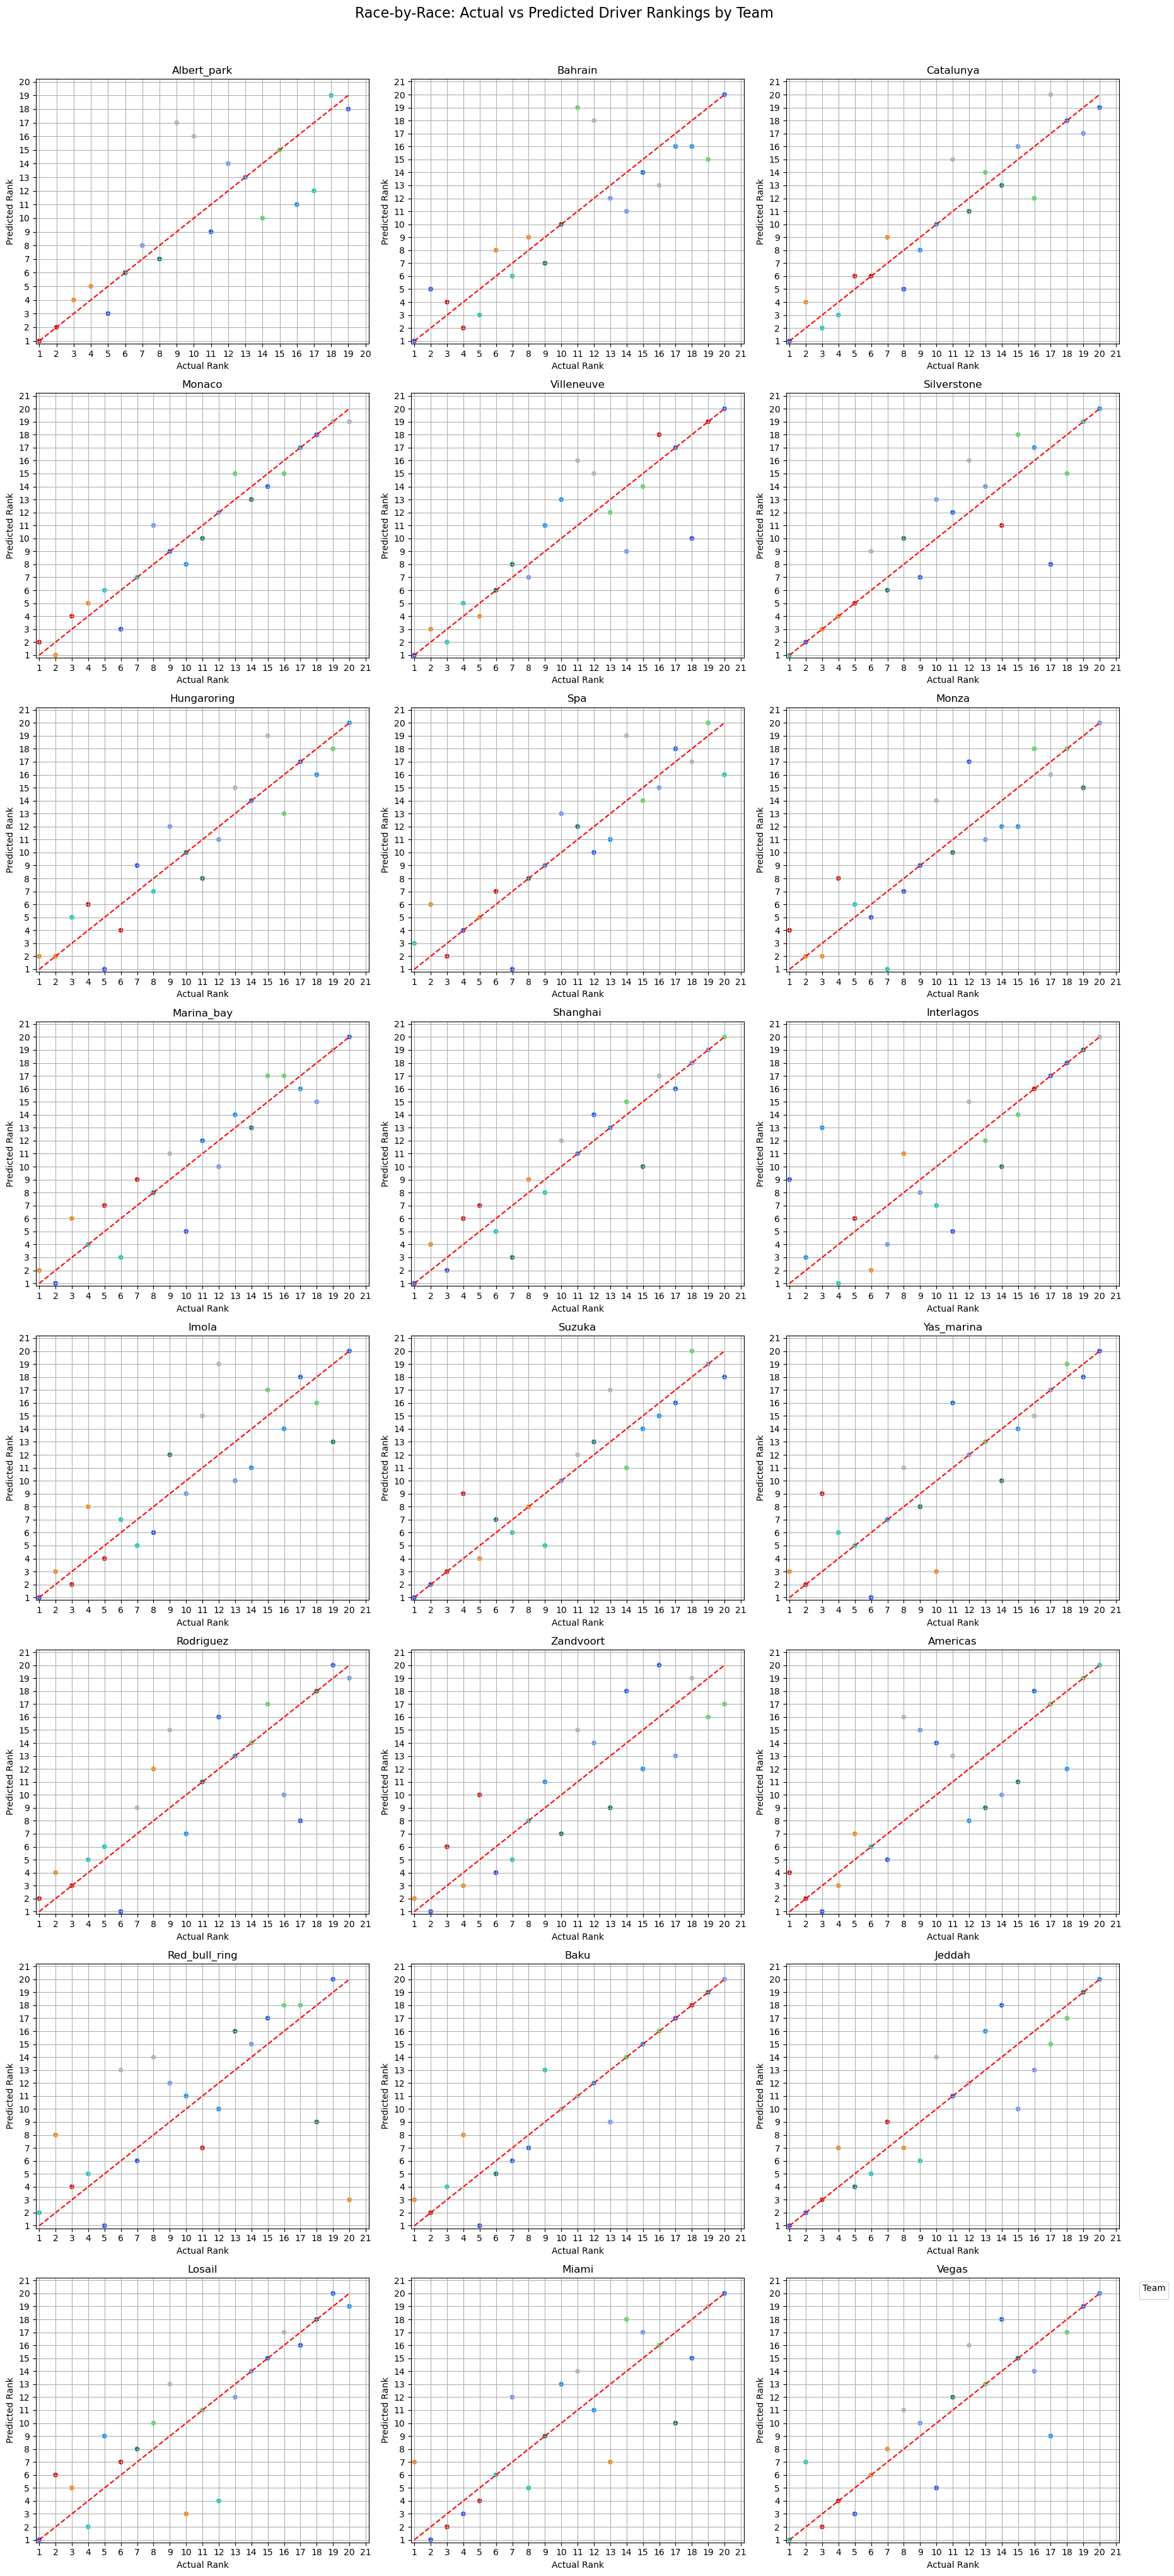

In [13]:
#adding team colors
team_colors = {
    'Red Bull': '#1E41FF',
    'Mercedes': '#00D2BE',
    'Ferrari': '#DC0000',
    'McLaren': '#FF8700',
    'Aston Martin': '#006F62',
    'Alpine F1 Team': '#0090FF',
    'Williams': '#005AFF',
    'RB F1 Team': '#6692FF',
    'Haas F1 Team': '#B6BABD',
    'Sauber': '#52E252',
    #fallback color
    'Other': '#888888'
}
palette = {team: color for team, color in team_colors.items() if team in test['team_name'].unique()}

#getting unique races
races = test['circuitRef'].unique()
n_races = len(races)

cols = 3
rows = math.ceil(n_races / cols)

plt.figure(figsize=(6 * cols, 5 * rows))

for idx, race in enumerate(races):
    ax = plt.subplot(rows, cols, idx + 1)
    
    race_data = test[test['circuitRef'] == race]
    
    sns.scatterplot(
        x='actual_rank', 
        y='predicted_rank', 
        hue='team_name', 
        data=race_data, 
        ax=ax,
        palette=palette,
        legend=False
    )
    
    #regression line
    ax.plot([1, race_data['actual_rank'].max()], [1, race_data['actual_rank'].max()], 'r--')
    
    #scale
    max_rank = int(max(race_data['actual_rank'].max(), race_data['predicted_rank'].max())) + 1
    ax.set_xticks(range(1, max_rank + 1))
    ax.set_yticks(range(1, max_rank + 1))
    
    ax.set_xlim(0.8, max_rank + 0.2)
    ax.set_ylim(0.8, max_rank + 0.2)

    ax.set_title(f'{race.capitalize()}')
    ax.set_xlabel('Actual Rank')
    ax.set_ylabel('Predicted Rank')
    ax.grid(True)

plt.tight_layout()
plt.suptitle('Race-by-Race: Actual vs Predicted Driver Rankings by Team', fontsize=16, y=1.02)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 8})
plt.show()

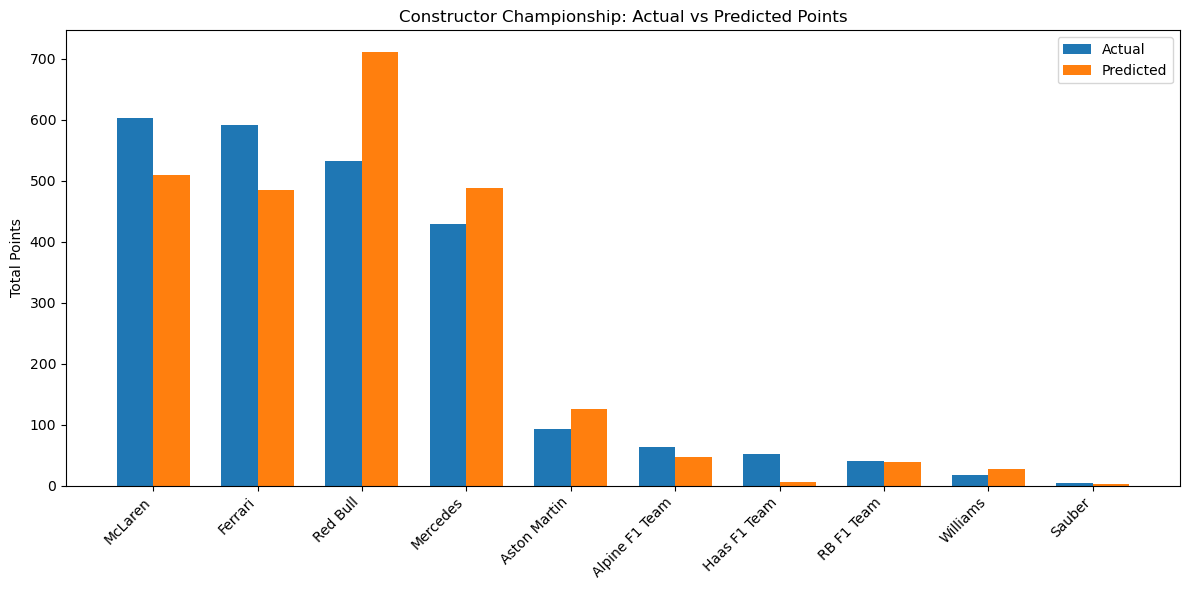

        team_name  actual_points  predicted_points
4         McLaren            603               509
2         Ferrari            591               485
7        Red Bull            533               711
5        Mercedes            429               488
1    Aston Martin             93               126
0  Alpine F1 Team             63                47
3    Haas F1 Team             51                 5
6      RB F1 Team             40                39
9        Williams             17                27
8          Sauber              4                 2


In [14]:
def position_to_points(pos):
    points_map = {1: 25, 2: 18, 3: 15, 4: 12, 5: 10,
                  6: 8, 7: 6, 8: 4, 9: 2, 10: 1}
    return points_map.get(pos, 0)

test['actual_points'] = test['actual_rank'].apply(position_to_points)
test['predicted_points'] = test['predicted_rank'].apply(position_to_points)

team_points = test.groupby(['team_name', 'circuitRef']).agg({
    'actual_points': 'sum',
    'predicted_points': 'sum'
}).reset_index()


season_totals = team_points.groupby('team_name').agg({
    'actual_points': 'sum',
    'predicted_points': 'sum'
}).reset_index()

#sorting by actual
season_totals = season_totals.sort_values(by='actual_points', ascending=False)


teams = season_totals['team_name']
x = np.arange(len(teams))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, season_totals['actual_points'], width, label='Actual')
ax.bar(x + width/2, season_totals['predicted_points'], width, label='Predicted')

ax.set_ylabel('Total Points')
ax.set_title('Constructor Championship: Actual vs Predicted Points')
ax.set_xticks(x)
ax.set_xticklabels(teams, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

print(season_totals)

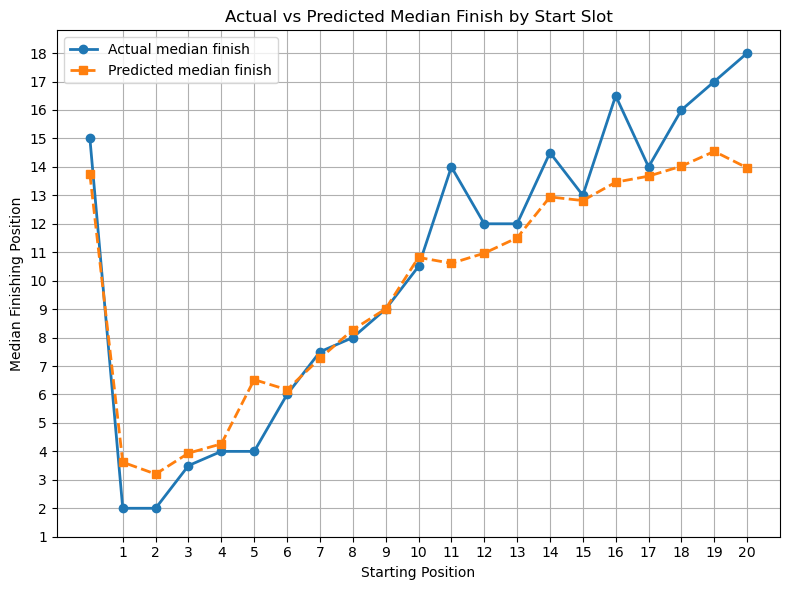

In [16]:
# 1) Reconstruct test DataFrame for plotting
plot_df = test.copy()
plot_df['y_pred'] = y_pred
plot_df['y_true'] = y_test.values

# 2) Compute ranks within each circuit
plot_df['actual_rank']    = plot_df.groupby('circuitRef')['y_true'].rank(method='min')
plot_df['predicted_rank'] = plot_df.groupby('circuitRef')['y_pred'].rank(method='min')


# 1) Compute medians by starting position
agg = plot_df.groupby('starting_pos').agg(
    actual_med   = ('y_true', 'median'),
    predicted_med= ('y_pred', 'median')
).reset_index()

# 2) Plot both curves
plt.figure(figsize=(8,6))
plt.plot(
    agg['starting_pos'],
    agg['actual_med'],
    marker='o',
    linewidth=2,
    label='Actual median finish'
)
plt.plot(
    agg['starting_pos'],
    agg['predicted_med'],
    marker='s',
    linestyle='--',
    linewidth=2,
    label='Predicted median finish'
)

# 3) Ticks at every integer
max_pos = int(agg['starting_pos'].max())
plt.xticks(range(1, max_pos+1))
plt.yticks(range(1, int(max(agg['actual_med'].max(), agg['predicted_med'].max()))+1))

# 4) Labels & styling
plt.xlabel('Starting Position')
plt.ylabel('Median Finishing Position')
plt.title('Actual vs Predicted Median Finish by Start Slot')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()